In [1]:
import pandas as pd

df = pd.read_csv("ncd_stock_data_featured.csv")
df.head()

,Date,Drug,Opening_Balance,Quantity_Received,Consumption,Losses_Adjustments,Closing_Balance,Days_Out_of_Stock,Stock_Out,month,year,quarter,consumption_lag_1,consumption_roll_mean_3
0,2020-03-01,Amlodipine 5mg,4650,7170,2047.0,50,9723,0,0,3,2020,1,2453.0,2250.000000
1,2020-04-01,Amlodipine 5mg,9723,0,2077.0,181,7465,0,0,4,2020,2,2047.0,2192.333333
2,2020-05-01,Amlodipine 5mg,7465,0,2685.0,26,4754,0,0,5,2020,2,2077.0,2269.666667
3,2020-06-01,Amlodipine 5mg,4754,7170,2363.0,29,9532,0,0,6,2020,2,2685.0,2375.000000
4,2020-07-01,Amlodipine 5mg,9532,0,2224.0,186,7122,0,0,7,2020,3,2363.0,2424.000000


# --- Model Training ---
*We will start with a simple, interpretable baseline model: Logistic Regression.*

In [2]:
from sklearn.model_selection import train_test_split

# Define Features (X) and Target (y)
y = df['Stock_Out']
X = df.drop(['Stock_Out', 'Date', 'Drug'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shape of the sets to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (486, 11)
Shape of X_test: (122, 11)


In [3]:
from sklearn.linear_model import LogisticRegression

# 1. Initialize the model
# We use class_weight='balanced' to help the model pay more attention to the rare 'Stock_Out' class
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=5000)

# 2. Train the model on the training data
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


In [4]:
#Make predictions on the test set (the data the model has never seen)
y_pred = model.predict(X_test)

print("Predictions made on the test set.")

Predictions made on the test set.


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        17

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122


--- Confusion Matrix ---


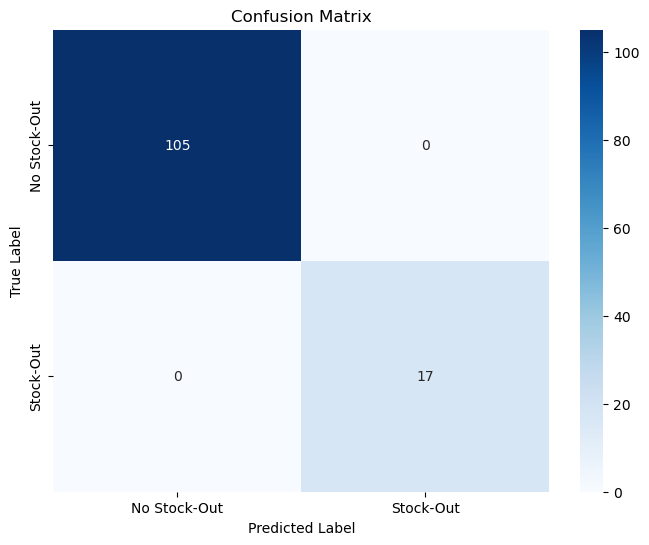

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Generate the Classification Report ---
# This gives us key metrics like Precision, Recall, and F1-score
print("--- Classification Report ---")
report = classification_report(y_test, y_pred)
print(report)


# --- Generate the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

# To make it easier to read, let's plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stock-Out', 'Stock-Out'], 
            yticklabels=['No Stock-Out', 'Stock-Out'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Model Interpretability with SHAP ---
*Goal: Understand the "why" behind our model's predictions. Which features are the most important drivers of stock-outs?*

C:\Users\DELL\anaconda3\envs\ncd_predictor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████| 122/122 [00:08<00:00, 15.05it/s]


--- SHAP Summary Plot ---


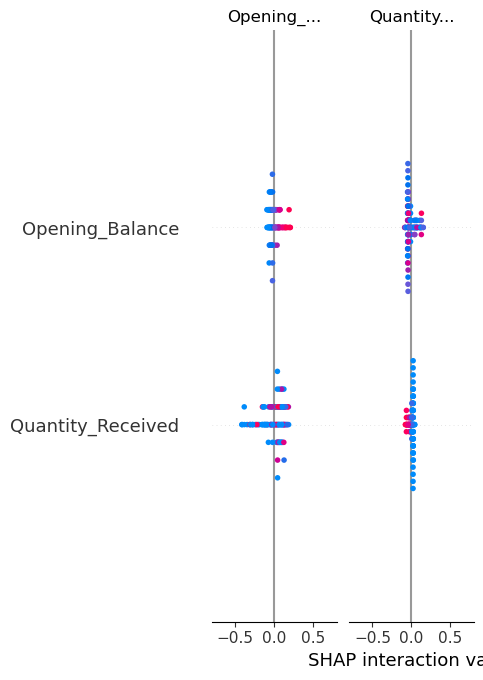

In [6]:
import shap
import matplotlib.pyplot as plt # We need to import this for saving

# --- This part is the same ---
# Create a SHAP explainer object
explainer = shap.KernelExplainer(model.predict_proba, X_train.sample(100))

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

print("--- SHAP Summary Plot ---")

# --- This is the same plot generation ---
shap.summary_plot(shap_values, X_test, show=False) # Add show=False to prevent it from displaying twice

# ====================================================================
# --- NEW CODE TO SAVE THE PLOT ---
# ====================================================================
# 1. Get the current plot figure and save it to a file.
#    'bbox_inches="tight"' is the magic command that automatically adjusts
#    the file's borders to make sure nothing is cut off.
plt.savefig("shap_summary_plot.png", bbox_inches="tight", dpi=150)

# 2. Explicitly show the plot in the notebook now that we're done saving.
plt.show()
# ====================================================================